### Аналитика в магазине чего-то там 

#### Цели проекта

В данном проекте нам предложено сделать анализ маркетинговых показателей магаза. Ко Ко Ко

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

visits = pd.read_csv('marketing_table.csv', sep=';')

visits['date'] = pd.to_datetime(visits["date"], format="%Y%m%d")
visits['month'] = visits['date'].apply(lambda w: w.strftime('%Y-%m'))

visits['weekday'] = visits['date'].apply(lambda w: w.weekday())
visits['weeknum'] = visits['date'].apply(lambda w: str(w.isocalendar()[0]) + '-' + str(w.isocalendar()[1]))

print(visits.shape)
visits.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(903653, 16)


,channelGrouping,date,visitStartTime,fullVisitorId,visitNumber,browser,deviceCategory,isMobile,operatingSystem,continent,country,subContinent,transactionRevenue,month,weekday,weeknum
0,Organic Search,2016-09-02,1472830385,1131660440785968503,1,Chrome,desktop,False,Windows,Asia,Turkey,Western Asia,NaN,2016-09,4,2016-35
1,Organic Search,2016-09-02,1472880147,377306020877927890,1,Firefox,desktop,False,Macintosh,Oceania,Australia,Australasia,NaN,2016-09,4,2016-35
2,Organic Search,2016-09-02,1472865386,3895546263509774583,1,Chrome,desktop,False,Windows,Europe,Spain,Southern Europe,NaN,2016-09,4,2016-35
3,Organic Search,2016-09-02,1472881213,4763447161404445595,1,UC Browser,desktop,False,Linux,Asia,Indonesia,Southeast Asia,NaN,2016-09,4,2016-35
4,Organic Search,2016-09-02,1472822600,27294437909732085,2,Chrome,mobile,True,Android,Europe,United Kingdom,Northern Europe,NaN,2016-09,4,2016-35


In [15]:
visits[['date', 'fullVisitorId', 'browser', 
        'deviceCategory', 'transactionRevenue']].to_csv('marketing_log.csv', sep='\t',index=False)

### 1. Сколько людей пользуются в день, неделю, месяц?

Среднее число посетителей в день: 2282.6420765027324


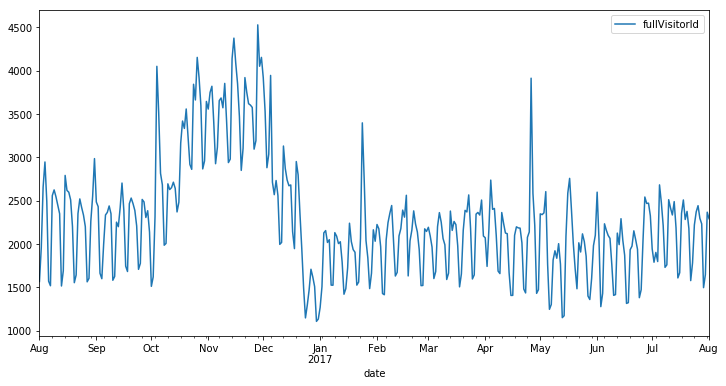

In [2]:
day = visits.groupby('date').agg({'fullVisitorId':'nunique'}).sort_index()
print(f"Среднее число посетителей в день: {day.fullVisitorId.mean()}")
day.plot(figsize=(12,6));

Среднее число посетителей в неделю: 15153.396226415094


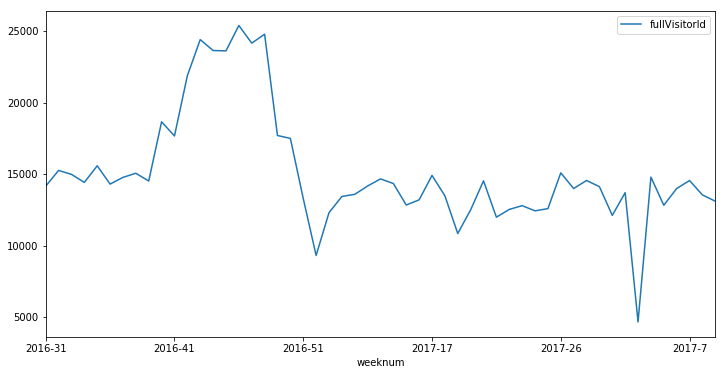

In [3]:
week = visits.groupby('weeknum').agg({'fullVisitorId': 'nunique'}).sort_index()
print(f"Среднее число посетителей в неделю: {week.fullVisitorId.mean()}")
week.plot(figsize=(12,6));

Среднее число посетителей в месяц: 59597.769230769234


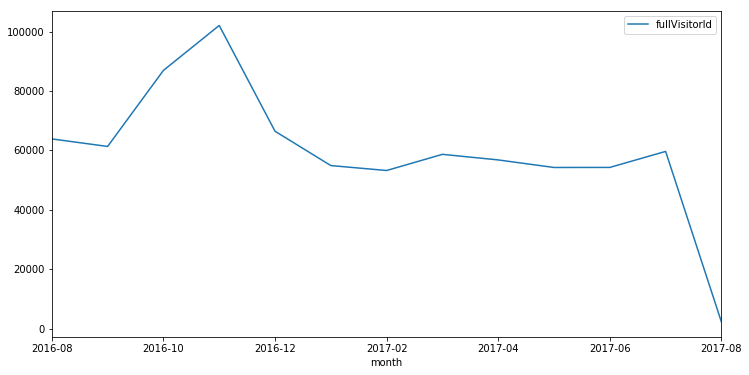

In [4]:
month = visits.groupby('month').agg({'fullVisitorId':'nunique'}).sort_index()
print(f"Среднее число посетителей в месяц: {month.fullVisitorId.mean()}")
month.plot(figsize=(12,6));

Основаня волна посещений магазина наблюдается осенью, летом идёт спад. Что-то спросить про сезонность и как она уходит при разных агрегациях.

### 2. Сколько сессий в день? 

Для этого нам необходимо сгруппировать по дням посещения и посчитать кол-во пользователей, не уникальных.

Среднее число сессий в день: 2468.997267759563


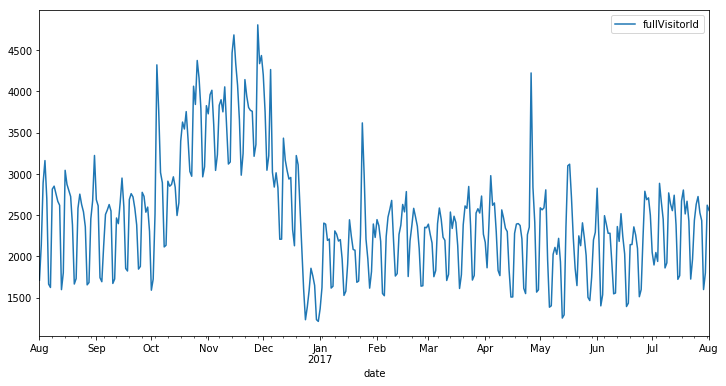

In [5]:
session_day = visits.groupby('date').agg({'fullVisitorId': 'count'})
print(f"Среднее число сессий в день: {session_day.fullVisitorId.mean()}")
session_day.plot(figsize=(12,6));

Видим, что график не сильно отличается от от `day`, это позволяет предположить, то что возвращаются люди очень редко. Проверим это.

### 3. Как часто люди возвращаются?

Чтобы ответить на этот вопрос воспользуемся когортным анализом, за когорту будем брать посетителей зарегистровавшихся в одном месяце.

In [6]:
first_month_session = visits.groupby('fullVisitorId').agg({'month':'min'})

first_month_session.columns = ['first_invate']
kogort_month = visits.join(first_month_session,on='fullVisitorId')

Выделили группы уникальных пользователей по месяцам, построим таблицу, которая покажет возврат пользователей на ресурс.

In [7]:
kogort_month = kogort_month[['fullVisitorId', 'month', 'first_invate']]
kogort_month.head()

,fullVisitorId,month,first_invate
0,1131660440785968503,2016-09,2016-09
1,377306020877927890,2016-09,2016-09
2,3895546263509774583,2016-09,2016-09
3,4763447161404445595,2016-09,2016-09
4,27294437909732085,2016-09,2016-08


In [8]:
sum(kogort_month.month != kogort_month.first_invate)

54908

In [9]:
revert = kogort_month.pivot_table(index='first_invate',
                        columns='month',
                        values = 'fullVisitorId',
                        aggfunc='nunique')

In [10]:
labels = list(kogort_month.month.unique())
labels.sort()
labels

['2016-08',
 '2016-09',
 '2016-10',
 '2016-11',
 '2016-12',
 '2017-01',
 '2017-02',
 '2017-03',
 '2017-04',
 '2017-05',
 '2017-06',
 '2017-07',
 '2017-08']

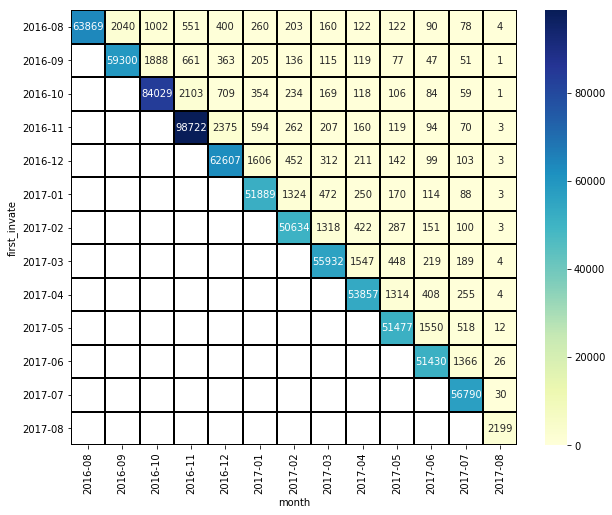

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(revert, annot=True, fmt='.0f',
            linewidths=1, linecolor='black', cmap="YlGnBu",
            xticklabels=labels, yticklabels=labels);

Какие-нибудь выводы про то, что мало людей возвращается.

Графики ретеншенов. 

### 4. Продажи 

* Когда люди начинают покупать? 

In [12]:
# Процент покупок 
100*(1 - visits['transactionRevenue'].isnull().sum()/visits.shape[0])

1.2742723147048718

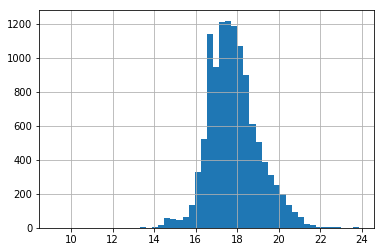

In [13]:
visits['transactionRevenue'].apply(np.log).hist(bins=50);

In [14]:
visits['transactionRevenue'] = visits['transactionRevenue']/10**6

In [15]:
invate_buy = visits.dropna(subset=['transactionRevenue'])

buy_date = invate_buy.groupby('fullVisitorId').agg({'date':'min'})
buy_date.columns = ['first_buy']

invate_buy = invate_buy.join(buy_date, on='fullVisitorId')

first_session = visits.groupby('fullVisitorId').agg({'date':'min'})
first_session.columns = ['first_invate']
invate_buy = invate_buy.join(first_session, on='fullVisitorId')

Найдём время от прихода до первой покупки в часах. 

In [16]:
invate_buy['deltatime_buy'] = (invate_buy['first_buy'] - invate_buy['first_invate'])/np.timedelta64(1,'h')

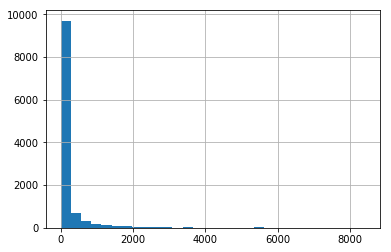

In [17]:
invate_buy['deltatime_buy'].hist(bins=30);

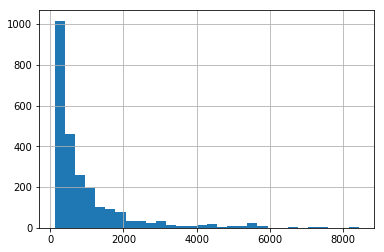

In [18]:
invate_buy[invate_buy['deltatime_buy'] > 100]['deltatime_buy'].hist(bins=30);

In [19]:
invate_buy['deltatime_buy'].describe()

count    11515.000000
mean       202.963092
std        655.523356
min          0.000000
25%          0.000000
50%          0.000000
75%         48.000000
max       8424.000000
Name: deltatime_buy, dtype: float64

__Ченить такое:__ 

Первую покупку совершают в ~20% случаев в течении первых 5 минут пользования. Так же много пользователей которые проводят более 30 минут: ~40%, прежде чем совершить покупку. Но это обусловлено индивидуальным характером и очень большим хвостом распределения, так как на графике не наблюдалось других пиков, распределение Пуассоновское и 40% пользователей распределены также. Из этого можно сделать вывод, что в челом пользователи в течении 1 сессии совершают покупку.

* Сколько раз покупают за период? 

In [20]:
first_buy = invate_buy.groupby('fullVisitorId').agg({'month':'min'})

first_buy.columns = ['first_buy_m']
kogort_month = invate_buy.join(first_buy, on='fullVisitorId')

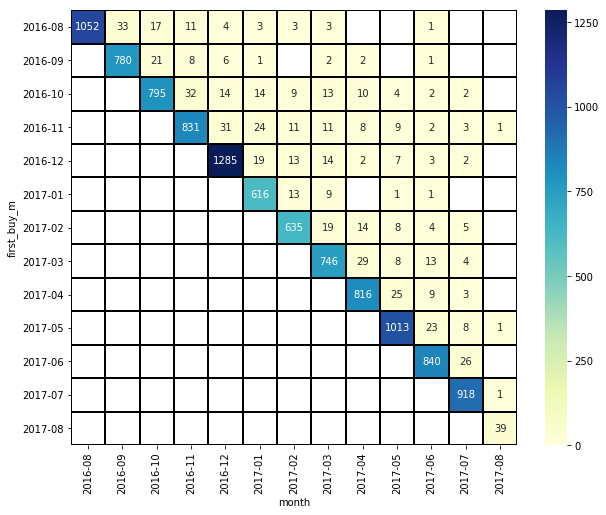

In [21]:
revert = kogort_month.pivot_table(index='first_buy_m',
                        columns='month',
                        values = 'fullVisitorId',
                        aggfunc='nunique')

labels = list(kogort_month.month.unique())
labels.sort()

plt.figure(figsize=(10, 8))
sns.heatmap(revert, annot=True, fmt='.0f',
            linewidths=1, linecolor='black', cmap="YlGnBu",
            xticklabels=labels, yticklabels=labels);

В основном пользователи покупают в 1 месяце пользования ресурсом. Дальше возвращаются редко. Посмотрим на график по месяцам.

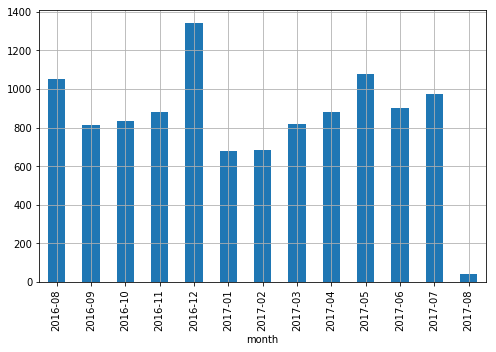

In [22]:
revert.sum().plot.bar(grid=True,figsize=(8,5))

* Какой средний чек? 

In [23]:
sum_buy = invate_buy.groupby('fullVisitorId').agg({'transactionRevenue':'sum'})
sum_buy.columns = ['revenue_sum']
kogort_month = kogort_month.join(sum_buy, on='fullVisitorId')

In [24]:
kogort_revenue = kogort_month.pivot_table(index='first_buy_m',
                        columns='month',
                        values = 'revenue_sum',
                        aggfunc='sum')

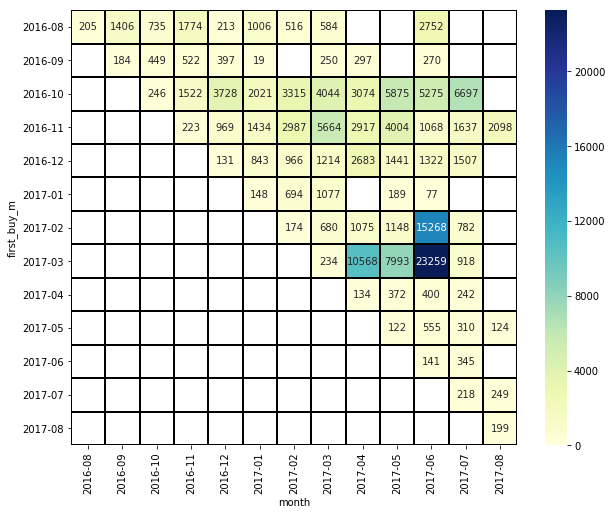

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(kogort_revenue/revert, annot=True, fmt='.0f',
            linewidths=1, linecolor='black', cmap="YlGnBu",
            xticklabels=labels, yticklabels=labels);

Проинтерпретировать числа из таблички

* Сколько денег приносят? (LTV) 

Взять картинок отсюда:

https://www.kaggle.com/kabure/exploring-the-consumer-patterns-ml-pipeline

__Есть гипотеза:__ кол-во посещений с Мобилок и ПК равны.

куда рекламу пихать 